# **Analysis of Calendar Anomalies in the BIST100 Index in 2015-2025**

## Introduction

This notebook examines calendar anomalies in the Turkish stock market through rigorous statistical analysis of the BIST100 index. calendar anomalies are systematic, calendar-based return patterns that challenge the Efficient Market Hypothesis by suggesting predictable deviations from market efficiency.

Using over a decade of data (January 2015 - September 2025), this study tests for two key anomalies: day-of-the-week effects and month-of-the-year effects. The analysis determines whether BIST100 returns exhibit statistically significant temporal variations, providing empirical evidence on market efficiency in emerging markets.

Workflow is following:
- compute log returns,
- check assumptions,
- apply Welch ANOVA for weekdays when variances are unequal, and
- apply one-way ANOVA for months. Detailed statistics appear in code outputs and 'test_result.md'.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg
import scikit_posthocs as sp

In [5]:
df = pd.read_csv("/content/drive/MyDrive/projects/bist100.csv")

### Dataset Overview
- Index: BIST100
- Period: January 2, 2015 to September 3, 2025
- Source: Investing.com historical data (manually downloaded)
- Variables: Date, Price, Open, High, Low, Volume, Change %

## Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676 entries, 0 to 2675
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2676 non-null   object
 1   Price     2676 non-null   object
 2   Open      2676 non-null   object
 3   High      2676 non-null   object
 4   Low       2676 non-null   object
 5   Vol.      2675 non-null   object
 6   Change %  2676 non-null   object
dtypes: object(7)
memory usage: 146.5+ KB


In [7]:
df.head(1)

,Date,Price,Open,High,Low,Vol.,Change %
0,01/02/2015,854.59,854.48,857.72,849.41,328.04M,-0.31%


In [8]:
numeric_columns = ['Price', 'Open', 'High', 'Low']
for col in numeric_columns:
    df[col] = df[col].str.replace(',', '').astype(float)

In [9]:
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df['Day'] = df['Date'].dt.day_name()

In [12]:
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
#Continuous Compund Returns - daily
df['Daily_Continuous_Return'] = np.log(df['Price'] / df['Price'].shift(1))

In [14]:
monthly_closings = df.groupby(df['Date'].dt.to_period('M'), as_index=False)[['Date','Price']].last()


In [15]:
monthly_closings['Month']=monthly_closings['Date'].dt.month_name()

In [16]:
monthly_closings['Monthly_Continuous_Return'] = np.log(monthly_closings['Price'] / monthly_closings['Price'].shift(1))

In [17]:
monthly_closings.head(3)

,Date,Price,Month,Monthly_Continuous_Return
0,2015-01-30,889.46,January,NaN
1,2015-02-27,841.48,February,-0.055452
2,2015-03-31,808.46,March,-0.040031


In [18]:
df.head(3)

,Date,Price,Open,High,Low,Vol.,Change %,Day,Daily_Continuous_Return
0,2015-01-02,854.59,854.48,857.72,849.41,328.04M,-0.31,Friday,NaN
1,2015-01-05,864.63,854.95,867.96,854.11,644.59M,1.17,Monday,0.011680
2,2015-01-06,869.10,866.51,869.12,855.75,698.32M,0.52,Tuesday,0.005157


In [19]:
day_counts = df['Day'].value_counts()
print(day_counts)

Day
Wednesday    538
Thursday     537
Monday       535
Friday       533
Tuesday      533
Name: count, dtype: int64


In [20]:
month_counts = monthly_closings['Month'].value_counts()
print(month_counts)

Month
January      11
February     11
March        11
April        11
May          11
June         11
July         11
August       11
September    11
October      10
November     10
December     10
Name: count, dtype: int64


In [21]:
df_day = df[['Day', 'Daily_Continuous_Return']]
df_month = monthly_closings[['Month', 'Monthly_Continuous_Return']]

## Calendar Anomalies Analysis

This section investigates whether statistically significant differences exist in the daily continuous returns of the dataset across different days of the week (Monday to Friday) and months of the year (January to December). The phenomena under investigation are calendar anomalies in financial markets, commonly referred to as the day-of-the-week effect and month-of-the-year effect.

**Day-of-the-Week Effect:**
- $H_0$: μ_Monday = μ_Tuesday = μ_Wednesday = μ_Thursday = μ_Friday
- $H_1$: At least one weekday mean differs

**Month-of-the-Year Effect:**
- $H_0$: μ_Jan = μ_Feb = ... = μ_Dec  
- $H_1$: At least one monthly mean differs

- The significance level (α) for this analysis is set at **0.05**.

### **Day-of-the-Week Effect:**

#### Normality Assumption Check


Friday - Shapiro-Wilk: statistic=0.9313438929141539, p-value=6.644562581272388e-15
Friday distribution is not normal.
--------------------------------------------------
Monday - Shapiro-Wilk: statistic=0.954539272769475, p-value=8.891068188497565e-12
Monday distribution is not normal.
--------------------------------------------------
Tuesday - Shapiro-Wilk: statistic=0.950944878207879, p-value=2.6492673637911814e-12
Tuesday distribution is not normal.
--------------------------------------------------
Wednesday - Shapiro-Wilk: statistic=0.9291176454257217, p-value=2.89961267775567e-15
Wednesday distribution is not normal.
--------------------------------------------------
Thursday - Shapiro-Wilk: statistic=0.9405936878452577, p-value=8.057565744284932e-14
Thursday distribution is not normal.
--------------------------------------------------


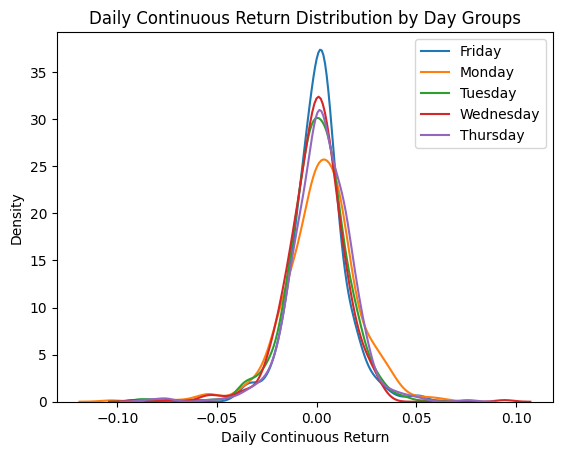

In [22]:
groups = {}
normality_results = {}

for day in df_day['Day'].unique():
    day_data = df_day[df_day['Day'] == day]['Daily_Continuous_Return'].dropna()

    groups[day] = day_data

    statistic, p_value = stats.shapiro(day_data)
    normality_results[day] = (statistic, p_value)

    print(f"{day} - Shapiro-Wilk: statistic={statistic:}, p-value={p_value:}")

    if p_value < 0.05:
        print(f"{day} distribution is not normal.")
    else:
        print(f"{day} distribution is normal.")

    print("-" * 50)
    sns.kdeplot(day_data, label=day)

plt.title('Daily Continuous Return Distribution by Day Groups')
plt.xlabel('Daily Continuous Return')
plt.ylabel('Density')
plt.legend()
plt.show()

* The first assumption for standard ANOVA requires that data within each group follow a normal distribution. To evaluate this assumption, the **Shapiro-Wilk test** was conducted on the daily returns for each day group.

* The p-values for all day groups were extremely small, substantially below the significance level of 0.05. Consequently, the null hypothesis of normality was rejected for every group. The accompanying kernel density plots provide visual confirmation of these findings. While the central portion of each distribution approximates a bell curve, the distributions exhibit pronounced fat tails, which represent a characteristic feature of financial return data. These extended tails indicate the presence of outliers, resulting in the failure of the normality test.

* Despite the failure of the normality test, a parametric test was employed. This decision was justified based on two fundamental statistical principles:
  1. **Central Limit Theorem (CLT):** Given the large sample size (approximately 535 observations per group), the sampling distribution of the means approaches normality regardless of the underlying population distribution. This theoretical foundation supports the validity of parametric procedures even when normality assumptions are violated at the individual observation level.
  2. **Robustness of ANOVA:** Analysis of variance demonstrates substantial robustness to departures from normality, particularly when sample sizes are large and relatively balanced across groups. Under these conditions, the Type I error rate remains approximately equal to the specified alpha level, ensuring the statistical inference maintains its intended properties.

#### Homogeneity of Variances Assumption Check

In [23]:
homojenity= stats.levene(groups['Monday'],groups['Tuesday'],groups['Wednesday'],groups['Thursday'],groups['Friday'])
print(f"statistic: {homojenity.statistic}, pvalue: {homojenity.pvalue}")

if homojenity.pvalue < 0.05:
    print("Ho is rejected: Variances are not homogeneous.")
else:
    print("H0 is accepted: Variances are homogeneous.")

statistic: 8.17707716604066, pvalue: 1.4964250282387501e-06
Ho is rejected: Variances are not homogeneous.


* The second key assumption for a standard ANOVA is the homogeneity of variances, which means that the variance within each group is approximately equal. This assumption was tested using the **Levene's Test**.

* **Result:**
    - Levene's Test Statistic: 8.17707716604066
    - p-value: 1.4964250282387501e-06

* The p-value is significantly smaller than the alpha level of 0.05. Therefore, the assumption that the variances are homogeneous is rejected. This finding indicates that the variances of the daily continuous returns are not equal across the day groups.

* Given the violation of the homogeneity of variances assumption, Welch's ANOVA was employed as the primary analytical method, as it is specifically designed to accommodate unequal variances between groups.

#### Welch ANOVA Test

In [24]:
anova = pg.welch_anova(data=df_day, dv='Daily_Continuous_Return', between='Day')
print("Welch ANOVA Results:")
print(anova)
print("-" * 60)

p_value = anova['p-unc'].iloc[0]
f_statistic = anova['F'].iloc[0]

print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.6f}")
print("-" * 60)

alpha = 0.05
if p_value < alpha:
    print(f"p-value ({p_value:.6f}) < α ({alpha}), The null hypothesis (Ho) is rejected .")
else:
    print(f"p-value ({p_value:.6f}) ≥ α ({alpha}),The null hypothesis (Ho) is not rejected.")


Welch ANOVA Results:
  Source  ddof1        ddof2         F     p-unc       np2
0    Day      4  1332.671539  3.266379  0.011219  0.004837
------------------------------------------------------------
F-statistic: 3.2664
p-value: 0.011219
------------------------------------------------------------
p-value (0.011219) < α (0.05), The null hypothesis (Ho) is rejected .


* **Test Results:**
    - F-statistic: 3.2664
    - p-value: 0.011219
    - np2: 0.004837

- Since p-value < α (0.05), **the null hypothesis ($H_0$) is rejected**.

- This indicates that **statistically significant evidence exists that at least one group mean differs significantly from the others**.
- In practical terms, the mean daily continuous returns are not equal across all days of the week, suggesting that the day-of-the-week effect is present in the data.

#### Post-Hoc Tests

In [25]:

# Perform Games-Howell post-hoc test
posthoc = pg.pairwise_gameshowell(data=df_day, dv='Daily_Continuous_Return', between='Day')

print(posthoc)

# Filter for statistically significant pairs (where p-value is less than 0.05)
significant = posthoc[posthoc['pval'] < 0.05]

# Check if any significant differences were found
if len(significant) > 0:
    print("\nThe post-hoc test identified statistically significant variations across groups at a significance level of 0.05:")
    for idx, row in significant.iterrows():
        print(f"{row['A']} vs {row['B']}: p = {row['pval']:.6f}")
else:
    print("\nNo significant difference found between any day pairs.")

          A          B   mean(A)   mean(B)      diff        se         T  \
0    Friday     Monday  0.000728  0.001920 -0.001191  0.001007 -1.182653   
1    Friday   Thursday  0.000728  0.002389 -0.001660  0.000901 -1.842865   
2    Friday    Tuesday  0.000728  0.000360  0.000368  0.000900  0.408975   
3    Friday  Wednesday  0.000728 -0.000667  0.001395  0.000891  1.565641   
4    Monday   Thursday  0.001920  0.002389 -0.000469  0.001044 -0.448931   
5    Monday    Tuesday  0.001920  0.000360  0.001560  0.001044  1.494240   
6    Monday  Wednesday  0.001920 -0.000667  0.002587  0.001036  2.496983   
7  Thursday    Tuesday  0.002389  0.000360  0.002028  0.000941  2.154811   
8  Thursday  Wednesday  0.002389 -0.000667  0.003055  0.000933  3.276156   
9   Tuesday  Wednesday  0.000360 -0.000667  0.001027  0.000932  1.101933   

            df      pval    hedges  
0   991.587106  0.761384 -0.072304  
1  1058.678801  0.349415 -0.112599  
2  1054.273712  0.994125  0.025044  
3  1063.149091 

The **Games-Howell test** was selected as the most appropriate post-hoc procedure due to the previously identified violation of the homogeneity of variances assumption.

**Results:**
- The analysis revealed only one pair with a statistically significant difference p-value < α (0.05).
- The difference was found between **Thursday** and **Wednesday**, with a p-value of **0.009568**.

All other pairwise comparisons were non-significant, with p-values exceeding the 0.05 threshold.

In [26]:

tamhane = sp.posthoc_tamhane(df_day, val_col='Daily_Continuous_Return', group_col='Day')
print(tamhane)

             Friday    Monday   Tuesday  Wednesday  Thursday
Friday     1.000000  0.741793  0.996781   0.465427  0.287805
Monday     0.741793  1.000000  0.516910   0.061819  0.995011
Tuesday    0.996781  0.516910  1.000000   0.793740  0.147444
Wednesday  0.465427  0.061819  0.793740   1.000000  0.005418
Thursday   0.287805  0.995011  0.147444   0.005418  1.000000


As a secondary post-hoc test, Tamhane's T2 test was also conducted to validate the findings. The results confirmed the previous analysis:
- The only p-value below the 0.05 significance level was for the comparison **between Thursday and Wednesday.**
- The p-value for this specific comparison was 0.00542.

#### Comparison of Post-Hoc Test Results

Comparing the results from both the Games-Howell and Tamhane's T2 tests reveals a strong consistency in the findings:

* **Games-Howell:** Thursday vs Wednesday: p = 0.009568
* **Tamhane's T2:** Thursday vs Wednesday: p = 0.005418

* Both tests, despite employing different calculation methods, reached the same conclusion. The only statistically significant difference in daily continuous returns is between Thursday and Wednesday. This agreement across robust tests provides high confidence in the reliability of these findings.

In [27]:
grp_m = df_day.groupby('Day')['Daily_Continuous_Return'].mean()*100
print(grp_m[['Monday','Tuesday','Wednesday', 'Thursday','Friday']])

Day
Monday       0.191993
Tuesday      0.036031
Wednesday   -0.066661
Thursday     0.238877
Friday       0.072848
Name: Daily_Continuous_Return, dtype: float64


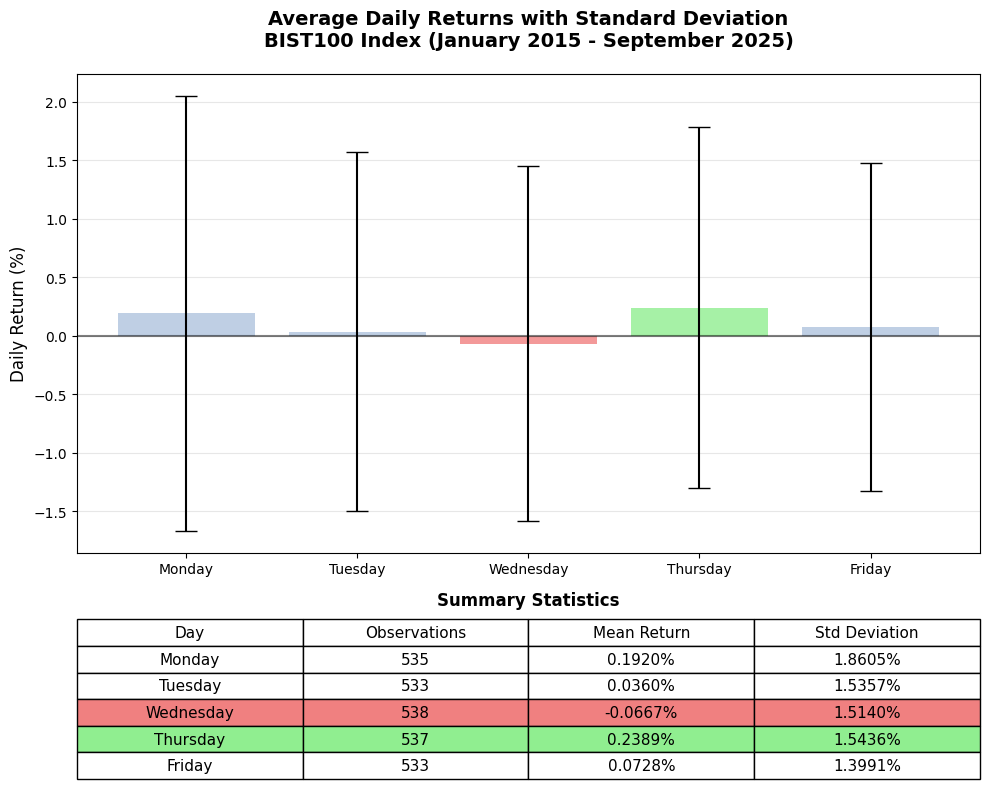

In [28]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
means = df_day.groupby('Day')['Daily_Continuous_Return'].mean() * 100
stds = df_day.groupby('Day')['Daily_Continuous_Return'].std() * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),
                               gridspec_kw={'height_ratios': [3, 1]})

# Top panel: Bar chart
bars = ax1.bar(range(len(day_order)), [means[day] for day in day_order],
               yerr=[stds[day] for day in day_order],
               capsize=8, alpha=0.8,
               color=['lightsteelblue', 'lightsteelblue', 'lightcoral', 'lightgreen', 'lightsteelblue'])

ax1.set_title('Average Daily Returns with Standard Deviation\nBIST100 Index (January 2015 - September 2025)',
              fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Daily Return (%)', fontsize=12)
ax1.set_xticks(range(len(day_order)))
ax1.set_xticklabels(day_order)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax1.grid(True, alpha=0.3, axis='y')

# Bottom panel: Summary table
table_data = []
for day in day_order:
    count = day_counts[day]
    mean_val = means[day]
    std_val = stds[day]
    table_data.append([day, f'{count:,}', f'{mean_val:.4f}%', f'{std_val:.4f}%'])

table = ax2.table(cellText=table_data,
                  colLabels=['Day', 'Observations', 'Mean Return', 'Std Deviation'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Style the table
for i in range(len(day_order)):
    if day_order[i] == 'Wednesday':
        table[(i+1, 0)].set_facecolor('lightcoral')
        table[(i+1, 1)].set_facecolor('lightcoral')
        table[(i+1, 2)].set_facecolor('lightcoral')
        table[(i+1, 3)].set_facecolor('lightcoral')
    elif day_order[i] == 'Thursday':
        table[(i+1, 0)].set_facecolor('lightgreen')
        table[(i+1, 1)].set_facecolor('lightgreen')
        table[(i+1, 2)].set_facecolor('lightgreen')
        table[(i+1, 3)].set_facecolor('lightgreen')

ax2.set_axis_off()
ax2.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

#### Conclusion

This analysis was conducted to determine whether statistically significant differences exist in daily continuous returns across different days of the week.

The initial assumption checks revealed that both the normality and homogeneity of variances assumptions were violated. However, based on the large sample size and the robustness of ANOVA, the decision was made to proceed with a parametric approach.

**Welch's ANOVA** was performed as the primary analysis, and the results indicated a statistically significant difference among the group means ($p < 0.05$). This led to the rejection of our initial null hypothesis.


To identify the specific pairs responsible for this difference, post-hoc tests were conducted. Both the **Games-Howell** and **Tamhane's T2** tests consistently showed that the only significant difference was found between **Thursday and Wednesday**. This finding is supported by the descriptive analysis, which revealed that Thursday exhibited the highest average daily return, while Wednesday showed the lowest and only negative average return.

In conclusion, our analysis provides strong evidence that daily continuous returns are not equal across all days of the week. This finding supports the existence of the day-of-the-week effect, a calendar anomaly, in the BIST100 between 2015-2025.

### **Month-of-the-Year Effect:**

In [29]:
df_month.head(2)

,Month,Monthly_Continuous_Return
0,January,NaN
1,February,-0.055452


In [30]:
month_groups = {}
month_normality_results = {}

for month in df_month['Month'].unique():
    month_data = df_month[df_month['Month'] == month]['Monthly_Continuous_Return'].dropna()

    month_groups[month] = month_data

    statistic, p_value = stats.shapiro(month_data)
    month_normality_results[month] = (statistic, p_value)

    print(f"{month} - Shapiro-Wilk: statistic={statistic:}, p-value={p_value:}")

    if p_value < 0.05:
        print(f"{month} distribution is not normal.")
    else:
        print(f"{month} distribution is normal.")

    print("-" * 50)

January - Shapiro-Wilk: statistic=0.9291262215179441, p-value=0.439352857471877
January distribution is normal.
--------------------------------------------------
February - Shapiro-Wilk: statistic=0.9755803417739833, p-value=0.9366505255693353
February distribution is normal.
--------------------------------------------------
March - Shapiro-Wilk: statistic=0.9766103821353486, p-value=0.9443931671257013
March distribution is normal.
--------------------------------------------------
April - Shapiro-Wilk: statistic=0.9691363632414517, p-value=0.8776790854350676
April distribution is normal.
--------------------------------------------------
May - Shapiro-Wilk: statistic=0.9225619376377341, p-value=0.34055895319393803
May distribution is normal.
--------------------------------------------------
June - Shapiro-Wilk: statistic=0.9364809372860026, p-value=0.4800519779166354
June distribution is normal.
--------------------------------------------------
July - Shapiro-Wilk: statistic=0.842

In [31]:
mhomojenity= stats.levene(month_groups['January'],month_groups['February'],month_groups['March'],month_groups['April'],
                         month_groups['May'], month_groups['June'],month_groups['July'], month_groups['August'], month_groups['September'],
                         month_groups['October'],month_groups['November'],month_groups['December'])
print(f"statistic: {mhomojenity.statistic}, pvalue: {mhomojenity.pvalue}")

if mhomojenity.pvalue < 0.05:
    print("Ho is rejected: Variances are not homogeneous.")
else:
    print("H0 is accepted: Variances are homogeneous.")

statistic: 1.087209484541159, pvalue: 0.37762171188328697
H0 is accepted: Variances are homogeneous.


Assumption testing for monthly data showed:
- **Normality:** Violated only for July (p = 0.0339)
- **Homogeneity:** Satisfied across all months (p = 0.3776)

The homogeneous variances and ANOVA's robustness to minor normality violations supported the use of **standard one-way ANOVA**.

In [32]:
oneway = pg.anova(data=df_month, dv='Monthly_Continuous_Return', between='Month',detailed=False)
print("oneway way ANOVA Results:")
print(oneway)
print("-" * 60)

pvalue = oneway['p-unc'].iloc[0]
fstatistic = oneway['F'].iloc[0]

print(f"F-statistic: {fstatistic:.4f}")
print(f"p-value: {pvalue:.6f}")
print("-" * 60)

alpha = 0.05
if pvalue < alpha:
    print(f"p-value ({pvalue:.6f}) < α ({alpha}), The null hypothesis (Ho) is rejected .")
else:
    print(f"p-value ({pvalue:.6f}) ≥ α ({alpha}),The null hypothesis (Ho) is not rejected.")


oneway way ANOVA Results:
  Source  ddof1  ddof2         F     p-unc       np2
0  Month     11    116  1.110527  0.359359  0.095275
------------------------------------------------------------
F-statistic: 1.1105
p-value: 0.359359
------------------------------------------------------------
p-value (0.359359) ≥ α (0.05),The null hypothesis (Ho) is not rejected.


In [33]:
grp_month = df_month.groupby('Month')['Monthly_Continuous_Return'].mean()*100
print(grp_month[['January','February','March', 'April','May','June','July','August','September','October','November','December']])

Month
January      4.486714
February    -0.577258
March       -2.255233
April        2.222791
May          0.265743
June         2.820928
July         4.102846
August       1.340776
September    0.776913
October      0.786794
November     6.488440
December     3.579793
Name: Monthly_Continuous_Return, dtype: float64


#### Conclusion
Assumption checks for the monthly data revealed that the normality assumption was violated only for July (p = 0.0339). However, the homogeneity of variances assumption was satisfied (p = 0.3776), as determined by Levene's test. Given that the variances were equal and the normality violation was minor, standard ANOVA was employed as it demonstrates robustness to modest deviations from normality assumptions.

The p-value of 0.359359 was obtained from the standard ANOVA results, which substantially exceeds the 0.05 significance level. Consequently, the null hypothesis was not rejected. This indicates an absence of Month-of-the-Year Effect patterns in BIST100 returns during 2015-2025.

## Conclusion

### **Day-of-the-Week Effect**
**Statistical Significance:** Welch's ANOVA detected significant differences across weekdays (F = 3.2664, p = 0.011219).
Post-hoc analyses revealed this effect was driven exclusively by the **Thursday-Wednesday** comparison (Games-Howell p = 0.009568, Tamhane's T2 p = 0.005418).


**Practical Significance:** Despite statistical detection, the effect size (η² = 0.0048) indicates the day-of-the-week-effect patterns explain less than 0.5% of return variance.


### **Month-of-the-Year Effect**
**No Statistical Evidence:** Standard ANOVA found no significant differences across calendar months (F = 1.1105, p = 0.359359). This result indicates an absence of a month-of-the-year effect in BIST100 returns during the 2015-2025 period.

### **Overall Assessment**
These findings contribute to the broader literature on market efficiency and calendar anomalies in emerging markets. The minimal explanatory power of detected day-of-the-week effects, combined with the complete absence of monthly patterns, suggests that calendar anomaly patterns are either non-existent or too small for meaningful exploitation in the BIST100 returns during 2015-2025.

## Disclaimer

This analysis is for academic and informational purposes only. This analysis is for academic and informational purposes only. It does not constitute or intend to provide financial or investment advice.